In [1]:
%load_ext autoreload
%autoreload 2

In [22]:
import os
from collections import OrderedDict
import sys
import copy
from pathlib import Path

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.utils import make_grid

sys.path.insert(0,'..')

import src.models.model_helpers as mh
from src.models.data_helpers import load_data
from src.models.train_model import train_model
from src.models.predict_model import test, predict
import src.models.visualise_helpers as vh

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

%matplotlib inline

In [3]:
torch.__version__

'1.7.0'

In [12]:
data_dir = Path('../data/raw/airlinersnet/')
models_dir = Path("../models/")
batch_size = 14
n_epochs = 1
model_tag = "airliners_net"
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [5]:
class_names, datasets, dataloaders = load_data(data_dir, batch_size)

In [6]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = make_grid(inputs)

#imshow(out, title=[class_names[x] for x in classes])

In [7]:
model = mh.initialize_model("densenet161", class_names, hidden_units=1104, dropout=0.4, device=device, freeze_model=False)

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [13]:
model, optimizer = mh.load_checkpoint(model, optimizer, models_dir / mh.gen_model_path(model, optimizer, model_tag))

Loading checkpoint:  ..\models\airliners_net_densenet161_SGD.pth


In [17]:
model, optimizer = train_model(model, optimizer, dataloaders, criterion, n_epochs, model_tag, models_dir)

Steps:   0%|                                                                                   | 0/803 [00:00<?, ?it/s]

Training airliners_net for 1 epochs on cuda

Model: densenet161
Criterion: SGD
Optimizer: CrossEntropyLoss

Loading previous 2 epochs



Steps: 100%|████████████████████████████████████████████████| 268/268 [00:53<00:00,  5.01it/s, Phase=valid, Loss=0.464]


--------
Epoch: 3/3..  Training Loss: 0.983..  Training Accuracy: 0.684..  Validation Loss: 0.464..  Validation Accuracy: 0.850
Saving checkpoint:  ..\models\airliners_net_densenet161_SGD.pth
Loading checkpoint:  ..\models\airliners_net_densenet161_SGD.pth


In [18]:
test_loss, test_accuracy, predicted_classes, correct_classes = test(dataloaders, model, criterion)

Test Loss: 0.446754
Test Accuracy: 85.71


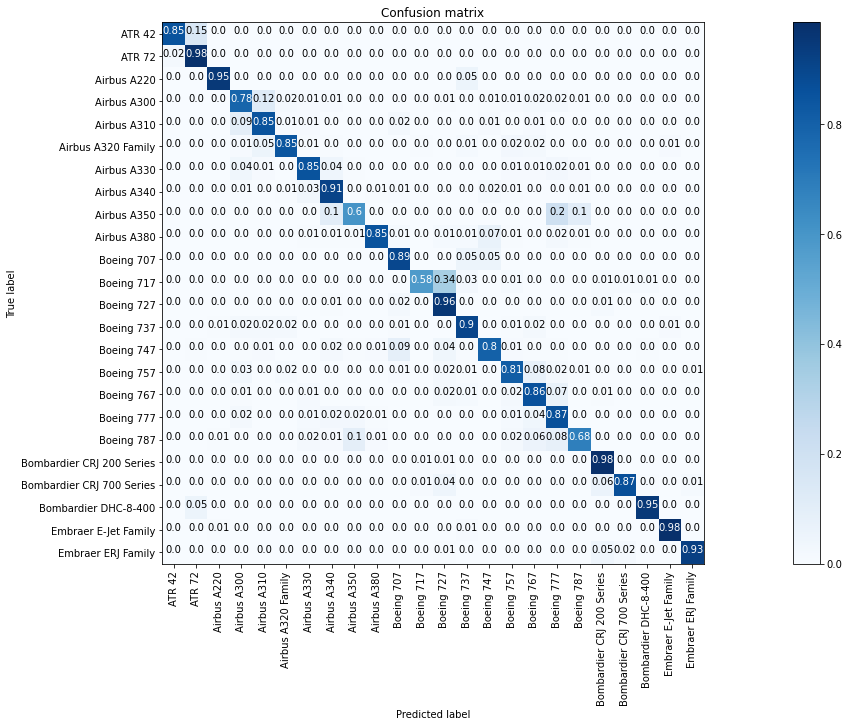

<module 'matplotlib.pyplot' from 'C:\\Anaconda3\\envs\\whatplane\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [26]:
vh.plot_confusion_matrix(predicted_classes, correct_classes, model.class_names, title='Confusion matrix', normalize=True)

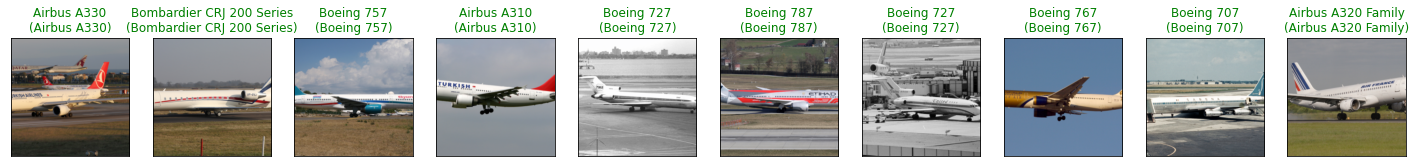

In [38]:
vh.visualize_results(dataloaders["test"], model)

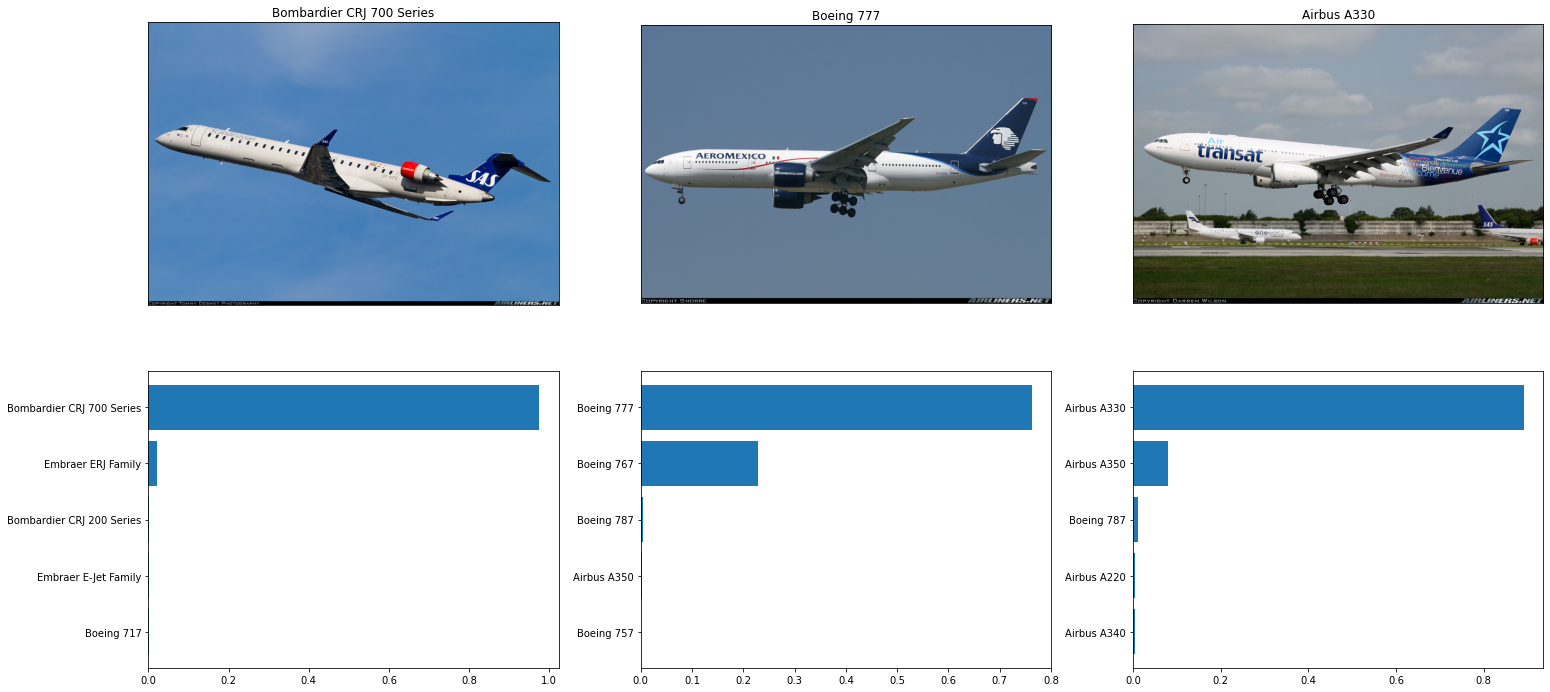

In [47]:
test_image_dir = Path("../data/raw/airlinersnet/test")
vh.predict_test_image_folder(test_image_dir, model)